In [1]:
%matplotlib notebook

In [2]:

from importlib import reload
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
import numpy as np
from numpy import dot
from copy import deepcopy
from two_transmons.Vacuum_rabi_windows import *
from transmon_chain.transmon_chain import *

In [3]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6
T1_3, T2_3 = 5e6, 1e6
T1_4, T2_4 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
tr3 = Transmon(Ec2, Ej2, d, 1/T1_3, 1/T2_3, Nc, N_trunc, 3)
tr4 = Transmon(Ec1, Ej1, d, 1/T1_4, 1/T2_4, Nc, N_trunc, 4)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)


<ipython-input-3-4d4e74eed59a>:27: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [4]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],0.6,0.7))
chain._transmons = [tr1, tr2,tr3,tr4]
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain.build_low_energy_kets(2,0)
chain._Ts = Ts
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.rho0 = rho0
sigma_z_chain = []
sigma_x_chain = []
sigma_y_chain = []
for i in range (4): #TO DO - вынести в функцию класса
    sigma_z = chain._transmons[i].sz()
    sigma_x = chain._transmons[i].sx()
    sigma_y = chain._transmons[i].sy()
    oper_z = chain._identity_array.copy()
    oper_z[i]=sigma_z
    oper_x = chain._identity_array.copy()
    oper_x[i]=sigma_x
    oper_y = chain._identity_array.copy()
    oper_y[i]=sigma_y
    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))
    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))
    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))

chain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain


Total 15 kets included


# Свободная эволюция системы

### 1й и 2й кубит в цепочке в резонансе, изначально первый кубит возбуждён

In [5]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0[0] = ket2dm((basis(3,1) + basis(3,0))/sqrt(2)) # задаём начальное состояние 1го кубита
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7


H_full_test = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full_test, rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

10.0%. Run time:   0.28s. Est. time left: 00:00:00:02
20.0%. Run time:   0.61s. Est. time left: 00:00:00:02
30.0%. Run time:   1.04s. Est. time left: 00:00:00:02
40.0%. Run time:   1.40s. Est. time left: 00:00:00:02
50.0%. Run time:   1.83s. Est. time left: 00:00:00:01
60.0%. Run time:   2.16s. Est. time left: 00:00:00:01
70.0%. Run time:   2.52s. Est. time left: 00:00:00:01
80.0%. Run time:   2.83s. Est. time left: 00:00:00:00
90.0%. Run time:   3.05s. Est. time left: 00:00:00:00
Total run time:   3.23s


<IPython.core.display.Javascript object>


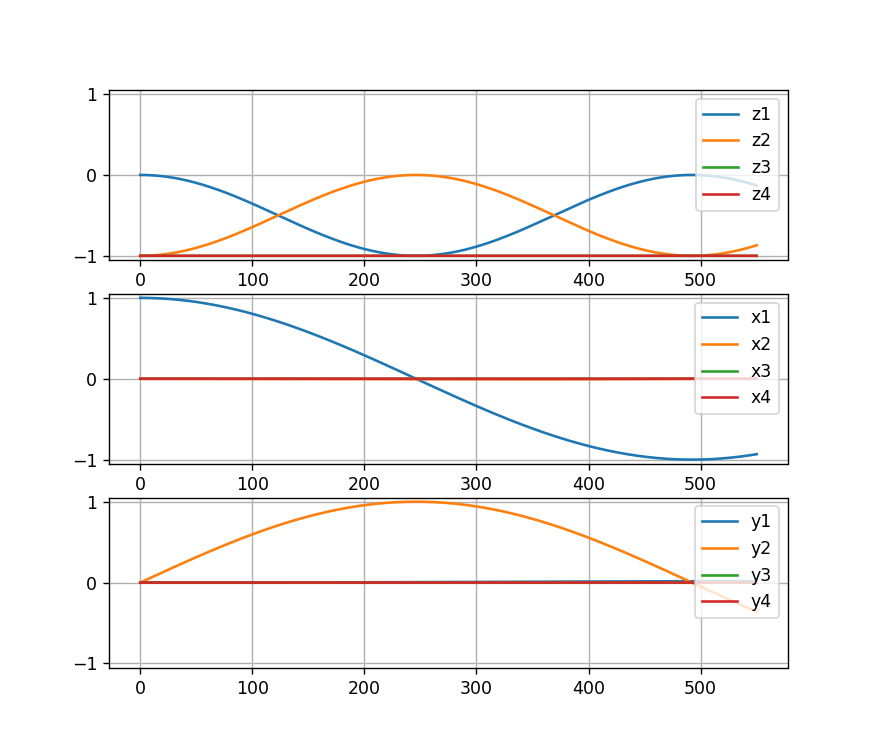

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [6]:
chain.plot_chain_dynamic(result)

## Эволюция под действием внешнего поля

### Кубиты не в резонансе, поле действует на первый и третий кубиты

In [31]:
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))

In [32]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.28s. Est. time left: 00:00:00:01
30.0%. Run time:   0.64s. Est. time left: 00:00:00:01
40.0%. Run time:   0.94s. Est. time left: 00:00:00:01
50.0%. Run time:   1.25s. Est. time left: 00:00:00:01
60.0%. Run time:   1.49s. Est. time left: 00:00:00:00
70.0%. Run time:   1.73s. Est. time left: 00:00:00:00
80.0%. Run time:   1.97s. Est. time left: 00:00:00:00
90.0%. Run time:   2.20s. Est. time left: 00:00:00:00
Total run time:   2.44s


<IPython.core.display.Javascript object>


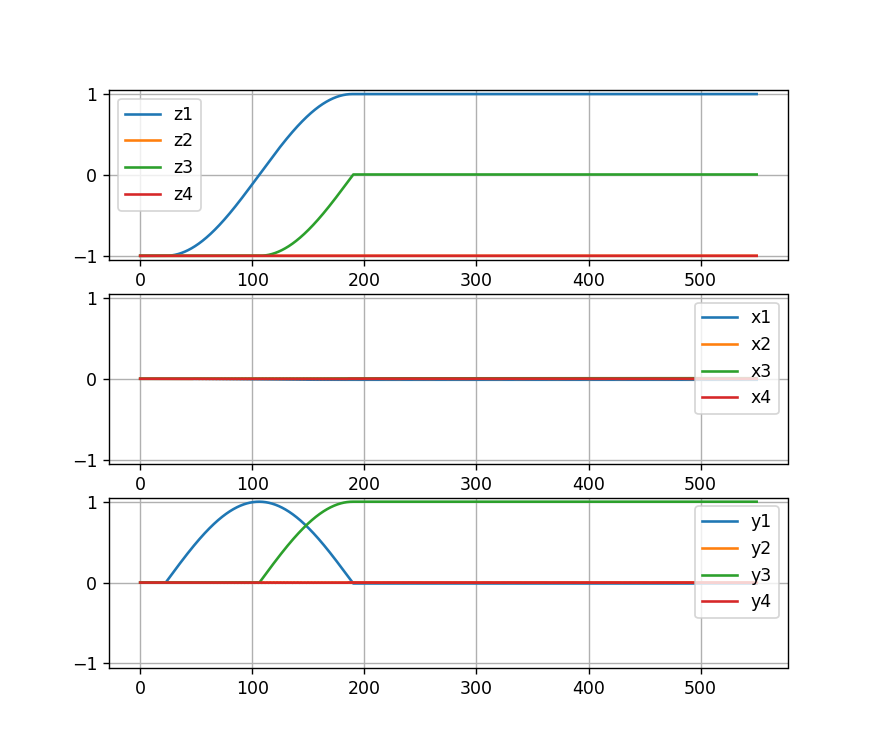

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [33]:
H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[T._pi_duration/2,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

### 1й, 2й и 3й кубиты в резонансе, поле действует на первый

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.51s. Est. time left: 00:00:00:02
30.0%. Run time:   1.09s. Est. time left: 00:00:00:02
40.0%. Run time:   1.85s. Est. time left: 00:00:00:02
50.0%. Run time:   2.76s. Est. time left: 00:00:00:02
60.0%. Run time:   3.67s. Est. time left: 00:00:00:02
70.0%. Run time:   4.58s. Est. time left: 00:00:00:01
80.0%. Run time:   5.49s. Est. time left: 00:00:00:01
90.0%. Run time:   6.41s. Est. time left: 00:00:00:00
Total run time:   7.33s


<IPython.core.display.Javascript object>


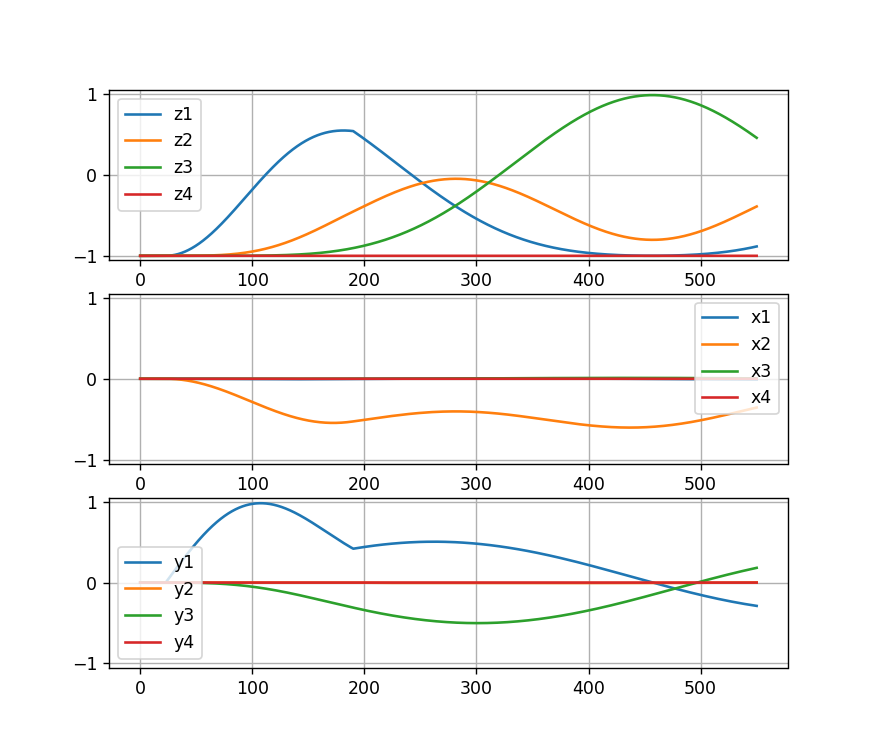

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [34]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform4_const = ones_like(Ts)*0.7
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],params['phi2z_base_level'],0.7))

H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Vacuum rabi oscillations

Приготавливаем первый кубит в возбуждённом состоянии, затем на какое-то время перестраиваем его по потоку. При попадании в резонанс со вторым кубитом наблюдаются осцилляции заселённости возбуждённого состояния 1-го и 2-го кубитов. Можно построить зависимость заселённости второго кубита от отстройки по потоку и времени взаимодействия. 

In [5]:
signal = ZPulse(Ts,params)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))



## Форма потокового импульса, подающегося на первый кубит (для одного значения параметров)

<IPython.core.display.Javascript object>


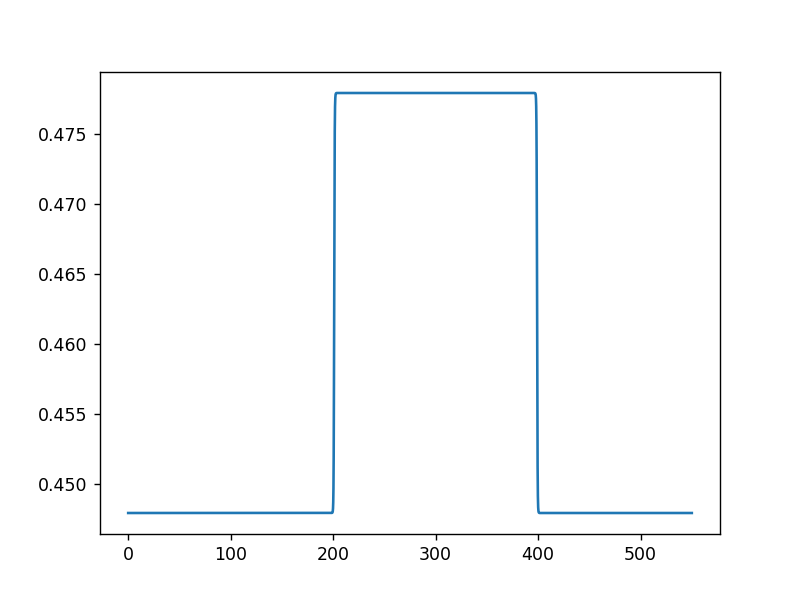

In [6]:
figure()
plot(Ts, vacuum_rabi_waveform(200, 0.03, Ts, params)[0])

In [7]:
##special for windows 
durations = linspace (50, 250, 50)
phis = linspace (0.025, 0.035, 200)
size = len(phis)
args = []
for ind, phi in enumerate (phis):
    dict_arg = {'chain' : chain, 'params' : params, 'durations' : durations, 'phi_offset' : phi}
    args.append(dict_arg)
    
if __name__=='__main__':
    with Pool(4) as p:
        populations = p.map(vacuum_rabi_populations_one_phi_windows, tqdm(args))

<ipython-input-7-8ea0f4891fce>:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  durations = linspace (50, 250, 10)
<ipython-input-7-8ea0f4891fce>:3: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phis = linspace (0.025, 0.035, 12)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [11:02<00:00, 55.22s/it]


<IPython.core.display.Javascript object>


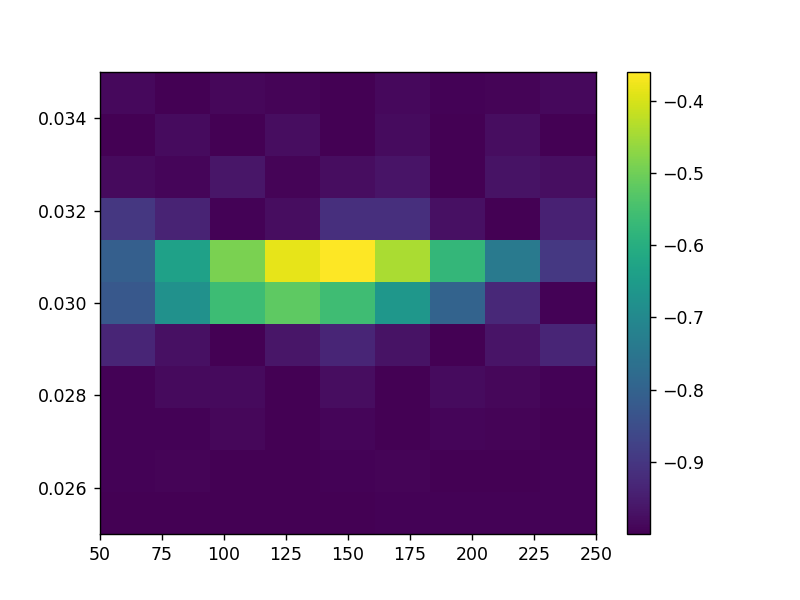

<ipython-input-8-ce29c927de75>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(durations, phis, populations)


In [8]:
figure()
pcolormesh(durations, phis, populations)
colorbar()
#savefig('01.12.2021_vacuum_rabi_4q.png')

## Iswap Gate

Пример эволюции кубитов при проведении гейта i-swap, первый кубит изначально переводится в состояние на экваторе сферы блоха, 
далее первый и второй кубиты переводятся в резонанс, после этого проводится фазовая коррекция с помощью Z-гейта.  

In [39]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0,0,0])
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7
H_full = chain.build_H_full([waveform1, waveform2, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration/2,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.45s. Est. time left: 00:00:00:01
40.0%. Run time:   0.78s. Est. time left: 00:00:00:01
50.0%. Run time:   1.39s. Est. time left: 00:00:00:01
60.0%. Run time:   2.01s. Est. time left: 00:00:00:01
70.0%. Run time:   2.61s. Est. time left: 00:00:00:01
80.0%. Run time:   3.16s. Est. time left: 00:00:00:00
90.0%. Run time:   3.31s. Est. time left: 00:00:00:00
Total run time:   3.45s


<IPython.core.display.Javascript object>

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

## Спектр системы в зависимости от потока через первый кубит

In [ ]:
levels = []

phis = linspace(0, 1, 3000)
for phi in tqdm(phis):
    phi_arr = [0.25, .5 , .6, .7]
    phi_arr[0] = phi
    chain.set_phi(phi_arr)
    waveform1_const = ones_like(Ts)*phi_arr[0]
    waveform2_const = ones_like(Ts)*phi_arr[1]
    waveform3_const = ones_like(Ts)*phi_arr[2]
    waveform4_const = ones_like(Ts)*phi_arr[3]
    H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]])
    H_const = chain.truncate_to_low_population_subspace(chain._zero_op)
    for i in range (12):
        if (i%3 != 2):
            H_const+=H_full[i][0]*H_full[i][1][0]
    for i in range(13,19,1):
        H_const+=H_full[i][0]
    evals, evecs = H_const.eigenstates()
    levels.append((evals-evals[0])/2/pi)

/tmp/ipykernel_2029482/647804778.py:3: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phis = linspace(0, 1, 3000)
  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
 88%|█████████████████████████████████████████████████████████████████████▏         | 2629/3000 [01:30<00:12, 29.74it/s]

In [ ]:
figure()
plot(phis, array(levels)[:, 1:6])
plot(phis, array(levels)[:, 6:21]/2, "--")